In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

Import the data from the different file provided by CoverMyMeds, then merge them into a single data set.

In [2]:
bridge = pd.read_csv("../data/bridge.csv")
dim_claims = pd.read_csv("../data/dim_claims.csv")
dim_pa = pd.read_csv("../data/dim_pa.csv")

In [3]:
df2 = bridge.merge(dim_claims, on='dim_claim_id', how='left').copy()
df4 = df2.merge(dim_pa, on='dim_pa_id', how='left').copy()

In [4]:
df4 = df4.fillna(-1) #Replace N/A with -1 for easier processing later

Now, we select on those rows where the claim was not approved and thus a PA is needed. We are predicting whether the PA will be approved, so that becomes our $y$. We divide into training and test data sets.

In [5]:
pa = df4[df4.pharmacy_claim_approved == 0].copy()
y = pa['pa_approved']

X_train,X_test,y_train,y_test = train_test_split(pa,y,
                                                 test_size = .25,
                                                 random_state = 614,
                                                 shuffle = True,
                                                 stratify = y)


In [6]:
#Hot Code Rejection Codes

rcd = pd.get_dummies(X_train['reject_code'])
X_train.loc[:,'not_in_formulary'] = pd.get_dummies(X_train['reject_code'])[70.0]
X_train.loc[:,'limit_exceeded'] = pd.get_dummies(X_train['reject_code'])[76.0]


        


/home/luke/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/luke/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [7]:
#Hot Code drugs

X_train.loc[:,'Drug A']=pd.get_dummies(X_train['drug'])['A']
X_train.loc[:,'Drug B']=pd.get_dummies(X_train['drug'])['B']



In [8]:
#Hot Code Payers. We leave out 999001; that will correspond to zeros in the three columns we create.

payers = X_train['bin'].unique()

for payer in payers:
    if(payer != 999001): 
        print(payer)
        X_train.loc[:,payer] = pd.get_dummies(X_train['bin'])[payer]

417380
417740
417614


Import necessary packages for running logistic regression and calculating performance metrics.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# import cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

Select on the features on which we are regressing.

In [11]:
features = ['correct_diagnosis','tried_and_failed','contraindication',
           'not_in_formulary','limit_exceeded','Drug A','Drug B',417380, 417740, 417614]
X_train = X_train[features] 


We will perform 10-fold cross validation

In [13]:
f=10
kfold = StratifiedKFold(f,shuffle=True,random_state=440)

Now, we actually train the model.

In [14]:
cutoffs = np.arange(0.0,1.0,.02)
z=0

accs = np.zeros((f,len(cutoffs)))
precs = np.zeros((f,len(cutoffs)))
recs = np.zeros((f,len(cutoffs)))
f1s = np.zeros((f,len(cutoffs)))

log_reg = LogisticRegression()


#y_prob = log_reg.predict_proba(X_train[features])[:,1] #Probability of Approval
fold = 0

for train_index,test_index in kfold.split(X_train,y_train):
    #print(train_index)
    #print(test_index)
    y_train_train,y_train_test = y_train.iloc[train_index],y_train.iloc[test_index]
    X_train_train =X_train.iloc[train_index]
    X_train_test = X_train.iloc[test_index]
    print("Now training fold",fold+1,"of",f)

    for j in range(len(cutoffs)):
        log_reg_clone = clone(log_reg)
        log_reg_clone.fit(X_train_train,y_train_train)
        probs = log_reg_clone.predict_proba(X_train_test)[:,1]
        
        y_pred = 1*(probs > cutoffs[j])
        accs[fold,j] = accuracy_score(y_train_test,y_pred)
        precs[fold,j] = precision_score(y_train_test,y_pred,zero_division=z)
        recs[fold,j] = recall_score(y_train_test,y_pred,zero_division=z)
        f1s[fold,j] = f1_score(y_train_test,y_pred,zero_division=z)
    fold=fold+1

print("Training Done!")

Now training fold 1 of 10
Now training fold 2 of 10
Now training fold 3 of 10
Now training fold 4 of 10
Now training fold 5 of 10
Now training fold 6 of 10
Now training fold 7 of 10
Now training fold 8 of 10
Now training fold 9 of 10
Now training fold 10 of 10
Training Done!


Our optimal cutoff at 0.36 gives is a recall of  0.96 with a precision of 0.81


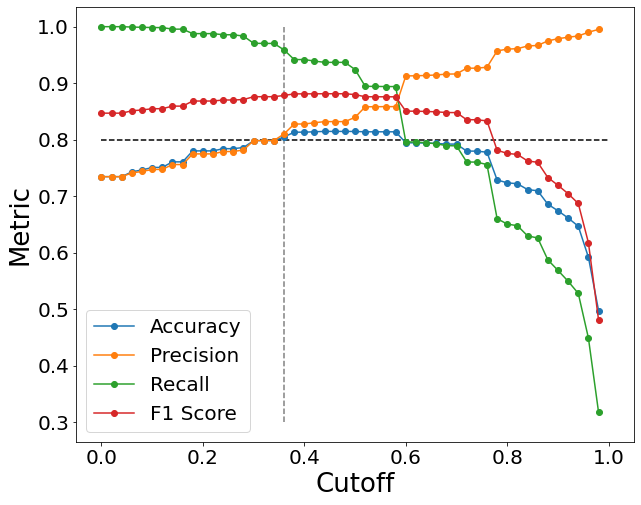

In [20]:
prec_guard = 0.8 #We optimize on recall with the constraint that precision is greater than this value.
prec = np.mean(precs,axis=0)
rec = np.mean(recs,axis=0)

prec2 = prec[prec>prec_guard]
rec2 = rec[prec>prec_guard]


#Find Highest recall with precision greater than guardrail value

l = np.argmax(rec2)
cot = cutoffs[prec>prec_guard]

print("Our optimal cutoff at",np.round(cot[l],2),"gives is a recall of ",np.round(rec2[l],2),
      "with a precision of",np.round(prec2[l],2))

opt_cut = cot[l]

plt.figure(figsize=(10,8))

plt.plot(cutoffs,np.mean(accs,axis=0),'o-',label="Accuracy")
plt.plot(cutoffs,np.mean(precs,axis=0),'o-',label="Precision")
plt.plot(cutoffs,np.mean(recs,axis=0),'o-',label="Recall")
plt.plot(cutoffs,np.mean(f1s,axis=0),'o-',label="F1 Score")


plt.xlabel("Cutoff", fontsize=26)
plt.ylabel("Metric", fontsize=26)

plt.legend(fontsize=20)

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.hlines(y=0.8,xmin=0.0,xmax=1.0,color='black',linestyles='dashed')
plt.vlines(x=cot[l],ymin=0.3,ymax=1.0,color='gray',linestyles='dashed')


plt.savefig("AllLogReg.jpg")
plt.show()




Retrain on entire training set and Pickle

In [17]:
import pickle


In [18]:
log_reg_train = LogisticRegression()
log_reg_train.fit(X_train,y_train)





LogisticRegression()

In [23]:
#Pickle!

outfile = open('../streamlined/log_reg.pcl','wb')
pickle.dump(log_reg_train,outfile)
outfile.close()

Now, let's run on the test set and see how close our recall is
